# Import the necessary Python libraries

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_squared_log_error 
from sklearn.model_selection import KFold,cross_val_predict, cross_val_score
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.pipeline import make_pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from category_encoders import TargetEncoder
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette("tab10")

# Loading Train and Test Datasets

In [73]:
training_dataset = pd.read_csv(r'../input/playground-series-s3e11/train.csv')
testing_dataset = pd.read_csv(r'../input/playground-series-s3e11/test.csv')

training_dataset.drop('id', axis = 1, inplace = True)
testing_ids=testing_dataset['id']
testing_dataset.drop('id', axis = 1, inplace = True)

# Loading Original Training Dataset

In [74]:
original_training_dataset = pd.read_csv(r'../input/media-campaign-cost-prediction/train_dataset.csv')

* Take a Quick Look at the Data Structure

In [75]:
training_dataset.head()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


In [76]:
testing_dataset.head()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
0,7.24,4.0,1.0,0.0,2.0,10.80,0.0,1.0,7.0,20319.0,0.0,0.0,0.0,0.0,0.0
1,6.90,2.0,2.0,2.0,3.0,8.51,1.0,0.0,4.0,33858.0,1.0,0.0,1.0,1.0,1.0
2,8.34,3.0,0.0,0.0,3.0,8.77,0.0,1.0,14.0,39696.0,0.0,0.0,1.0,1.0,0.0
3,5.48,2.0,3.0,3.0,2.0,21.90,1.0,0.0,9.0,23688.0,1.0,1.0,1.0,1.0,1.0
4,4.80,3.0,2.0,0.0,2.0,10.90,1.0,0.0,11.0,27694.0,1.0,1.0,1.0,1.0,1.0


In [77]:
original_training_dataset.head()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,2.68,2.0,1.0,0.0,2.0,6.30,1.0,0.0,22.0,30584.0,1.0,1.0,1.0,1.0,1.0,79.59
1,5.73,3.0,5.0,5.0,3.0,18.70,1.0,0.0,30.0,20319.0,0.0,0.0,0.0,0.0,0.0,118.36
2,2.62,2.0,1.0,1.0,1.0,9.21,0.0,0.0,9.0,20319.0,0.0,0.0,0.0,0.0,0.0,67.20
3,11.73,3.0,1.0,1.0,3.0,10.90,1.0,1.0,15.0,23112.0,1.0,1.0,1.0,1.0,1.0,60.87
4,4.82,2.0,1.0,1.0,3.0,8.15,0.0,0.0,7.0,38382.0,0.0,0.0,0.0,0.0,0.0,86.79


# Data Pre-processing

## Check for Missing Values

In [78]:
def count_missing_values(df :pd.DataFrame):
    # Count missing values in each column
    missing_values = df.isnull().sum()
    
    # Total missing values in the DataFrame
    total_missing = missing_values.sum()
    
    return total_missing

1. Training Dataset

In [79]:
print("\nTotal missing values in the Training Dataset:",count_missing_values(training_dataset))


Total missing values in the Training Dataset: 0


2. Testing Dataset

In [80]:
print("\nTotal missing values in the Testing Dataset:",count_missing_values(testing_dataset))


Total missing values in the Testing Dataset: 0


3. Original Training Dataset

In [81]:
print("\nTotal missing values in the original training dataset Dataset:", count_missing_values(original_training_dataset))


Total missing values in the original training dataset Dataset: 0


## Check for Duplicates Values

In [82]:
def count_duplicate_rows(df):
    # Check for duplicate rows
    duplicate_rows = df[df.duplicated()]
    
    # Count the number of duplicate rows
    num_duplicate_rows = duplicate_rows.shape[0]
    
    return num_duplicate_rows

1. Training Dataset

In [83]:
print("\nNumber of duplicate rows:", count_duplicate_rows(training_dataset))


Number of duplicate rows: 0


2. Testing Dataset

In [84]:
print("\nNumber of duplicate rows:", count_duplicate_rows(testing_dataset))


Number of duplicate rows: 0


3. Original Training Dataset

In [85]:
print("\nNumber of duplicate rows:", count_duplicate_rows(original_training_dataset))


Number of duplicate rows: 35


## Remove Duplicates Values

In [86]:
# Remove duplicate rows
original_training_dataset = original_training_dataset.drop_duplicates()

# Exploratory Data Analysis

## Visualize Feature Distribution

In [87]:
def plot_feature_distributions(training_df, testing_df, original_training_df, palette):
    fig, ax = plt.subplots(5, 3, figsize=(10, 13), dpi=300)
    ax = ax.flatten()

    for i, column in enumerate(testing_df.columns):
        sns.kdeplot(training_df[column], ax=ax[i], color=palette[0])
        sns.kdeplot(testing_df[column], ax=ax[i], color=palette[2])
        sns.kdeplot(original_training_df[column], ax=ax[i], color=palette[1])

        ax[i].set_title(f'{column} Distribution')
        ax[i].set_xlabel(None)

    fig.suptitle('Distribution of Feature\nper Dataset\n', fontsize=24, fontweight='bold')
    fig.legend(['Train', 'Test', 'Original Train'])
    plt.tight_layout()
    plt.show()


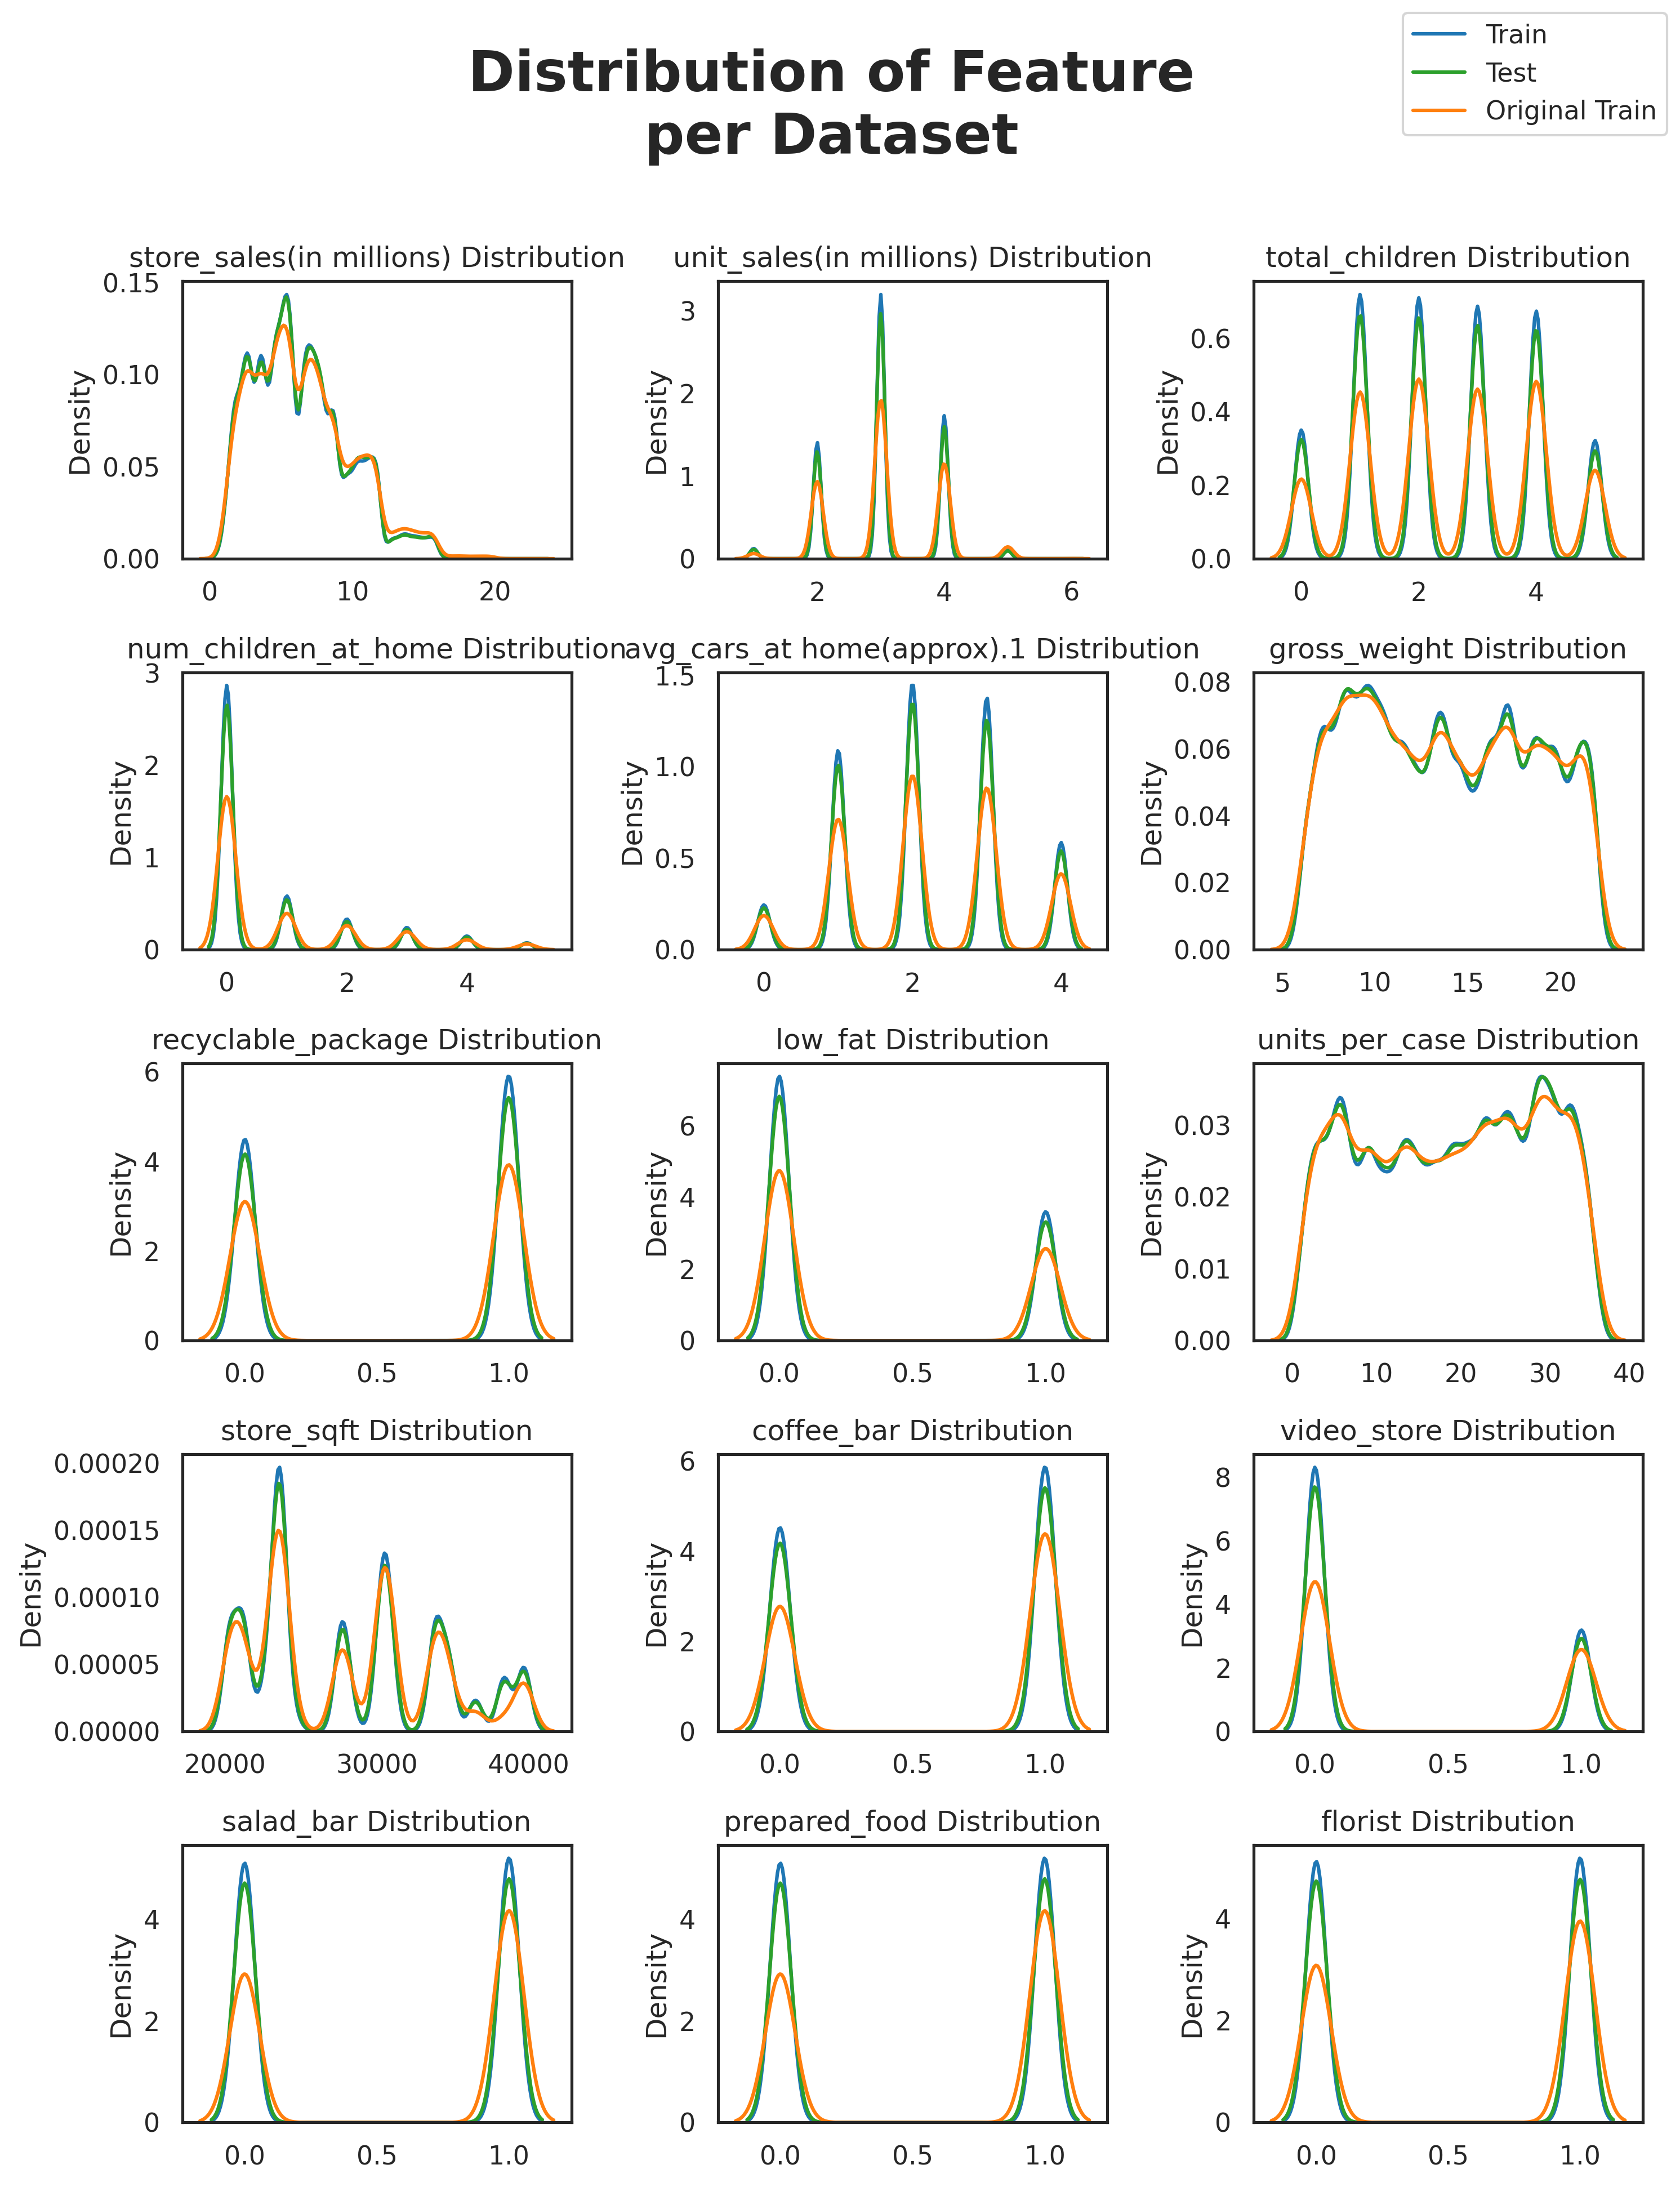

In [88]:
plot_feature_distributions(training_dataset, testing_dataset, original_training_dataset, pal)

## Visualize Cost Distribution Per Train vs Original Train Datasets

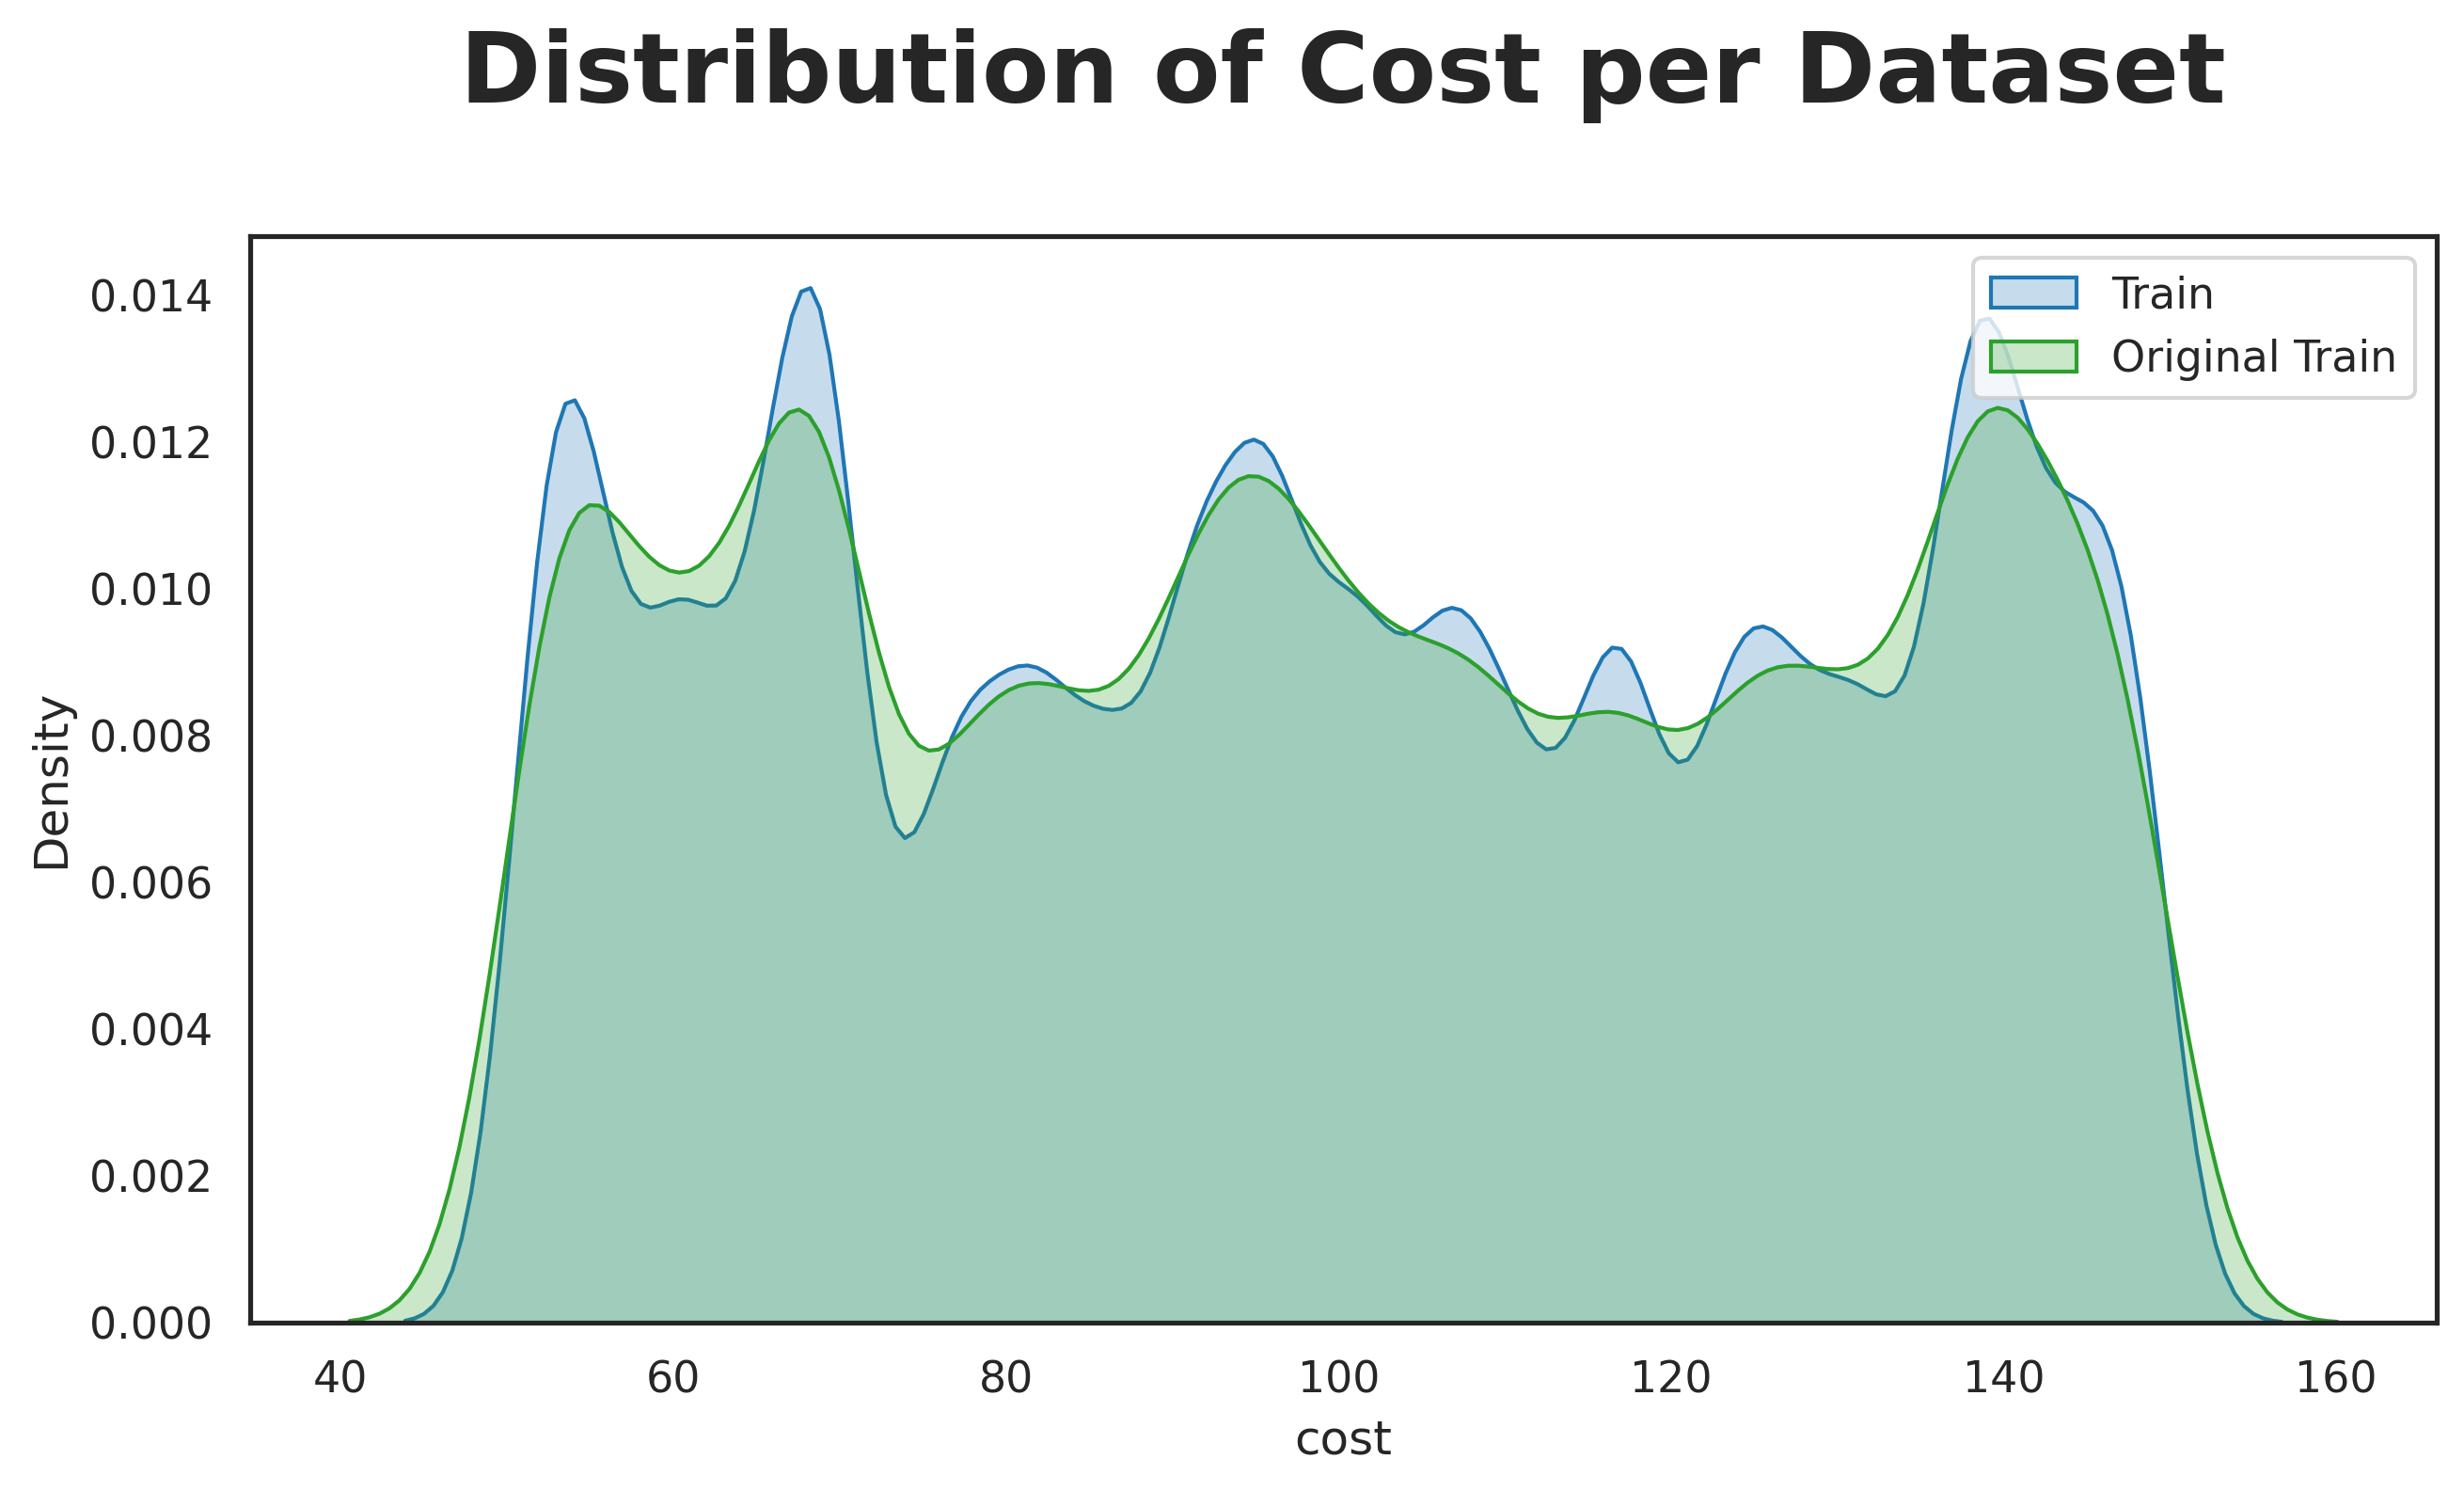

In [89]:
plt.figure(figsize = (10, 5), dpi = 300)

sns.kdeplot(training_dataset['cost'], color = pal[0], fill = True)
sns.kdeplot(original_training_dataset['cost'], color = pal[2], fill = True)

plt.title('Distribution of Cost per Dataset\n', weight = 'bold', fontsize = 25)
plt.legend(['Train', 'Original Train'])
plt.show()

* The distribution in both the original datasets and the competition datasets appears to be quite similar.

## Visualize Correlation Matrix

In [90]:
def plot_correlation_heatmap(data, label=None):
    correlation_matrix = data.corr()
    plt.figure(figsize=(14, 10), dpi=300)
    
    # Create a mask to hide the upper triangle of the heatmap
    mask = np.zeros_like(correlation_matrix)
    mask[np.triu_indices_from(mask)] = True
    
    sns.heatmap(correlation_matrix, mask=mask, annot=True, annot_kws={'size': 7})
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.title(f'Correlation Matrix for {label} Dataset\n', fontsize=25, weight='bold')
    plt.show()

1. Training Dataset

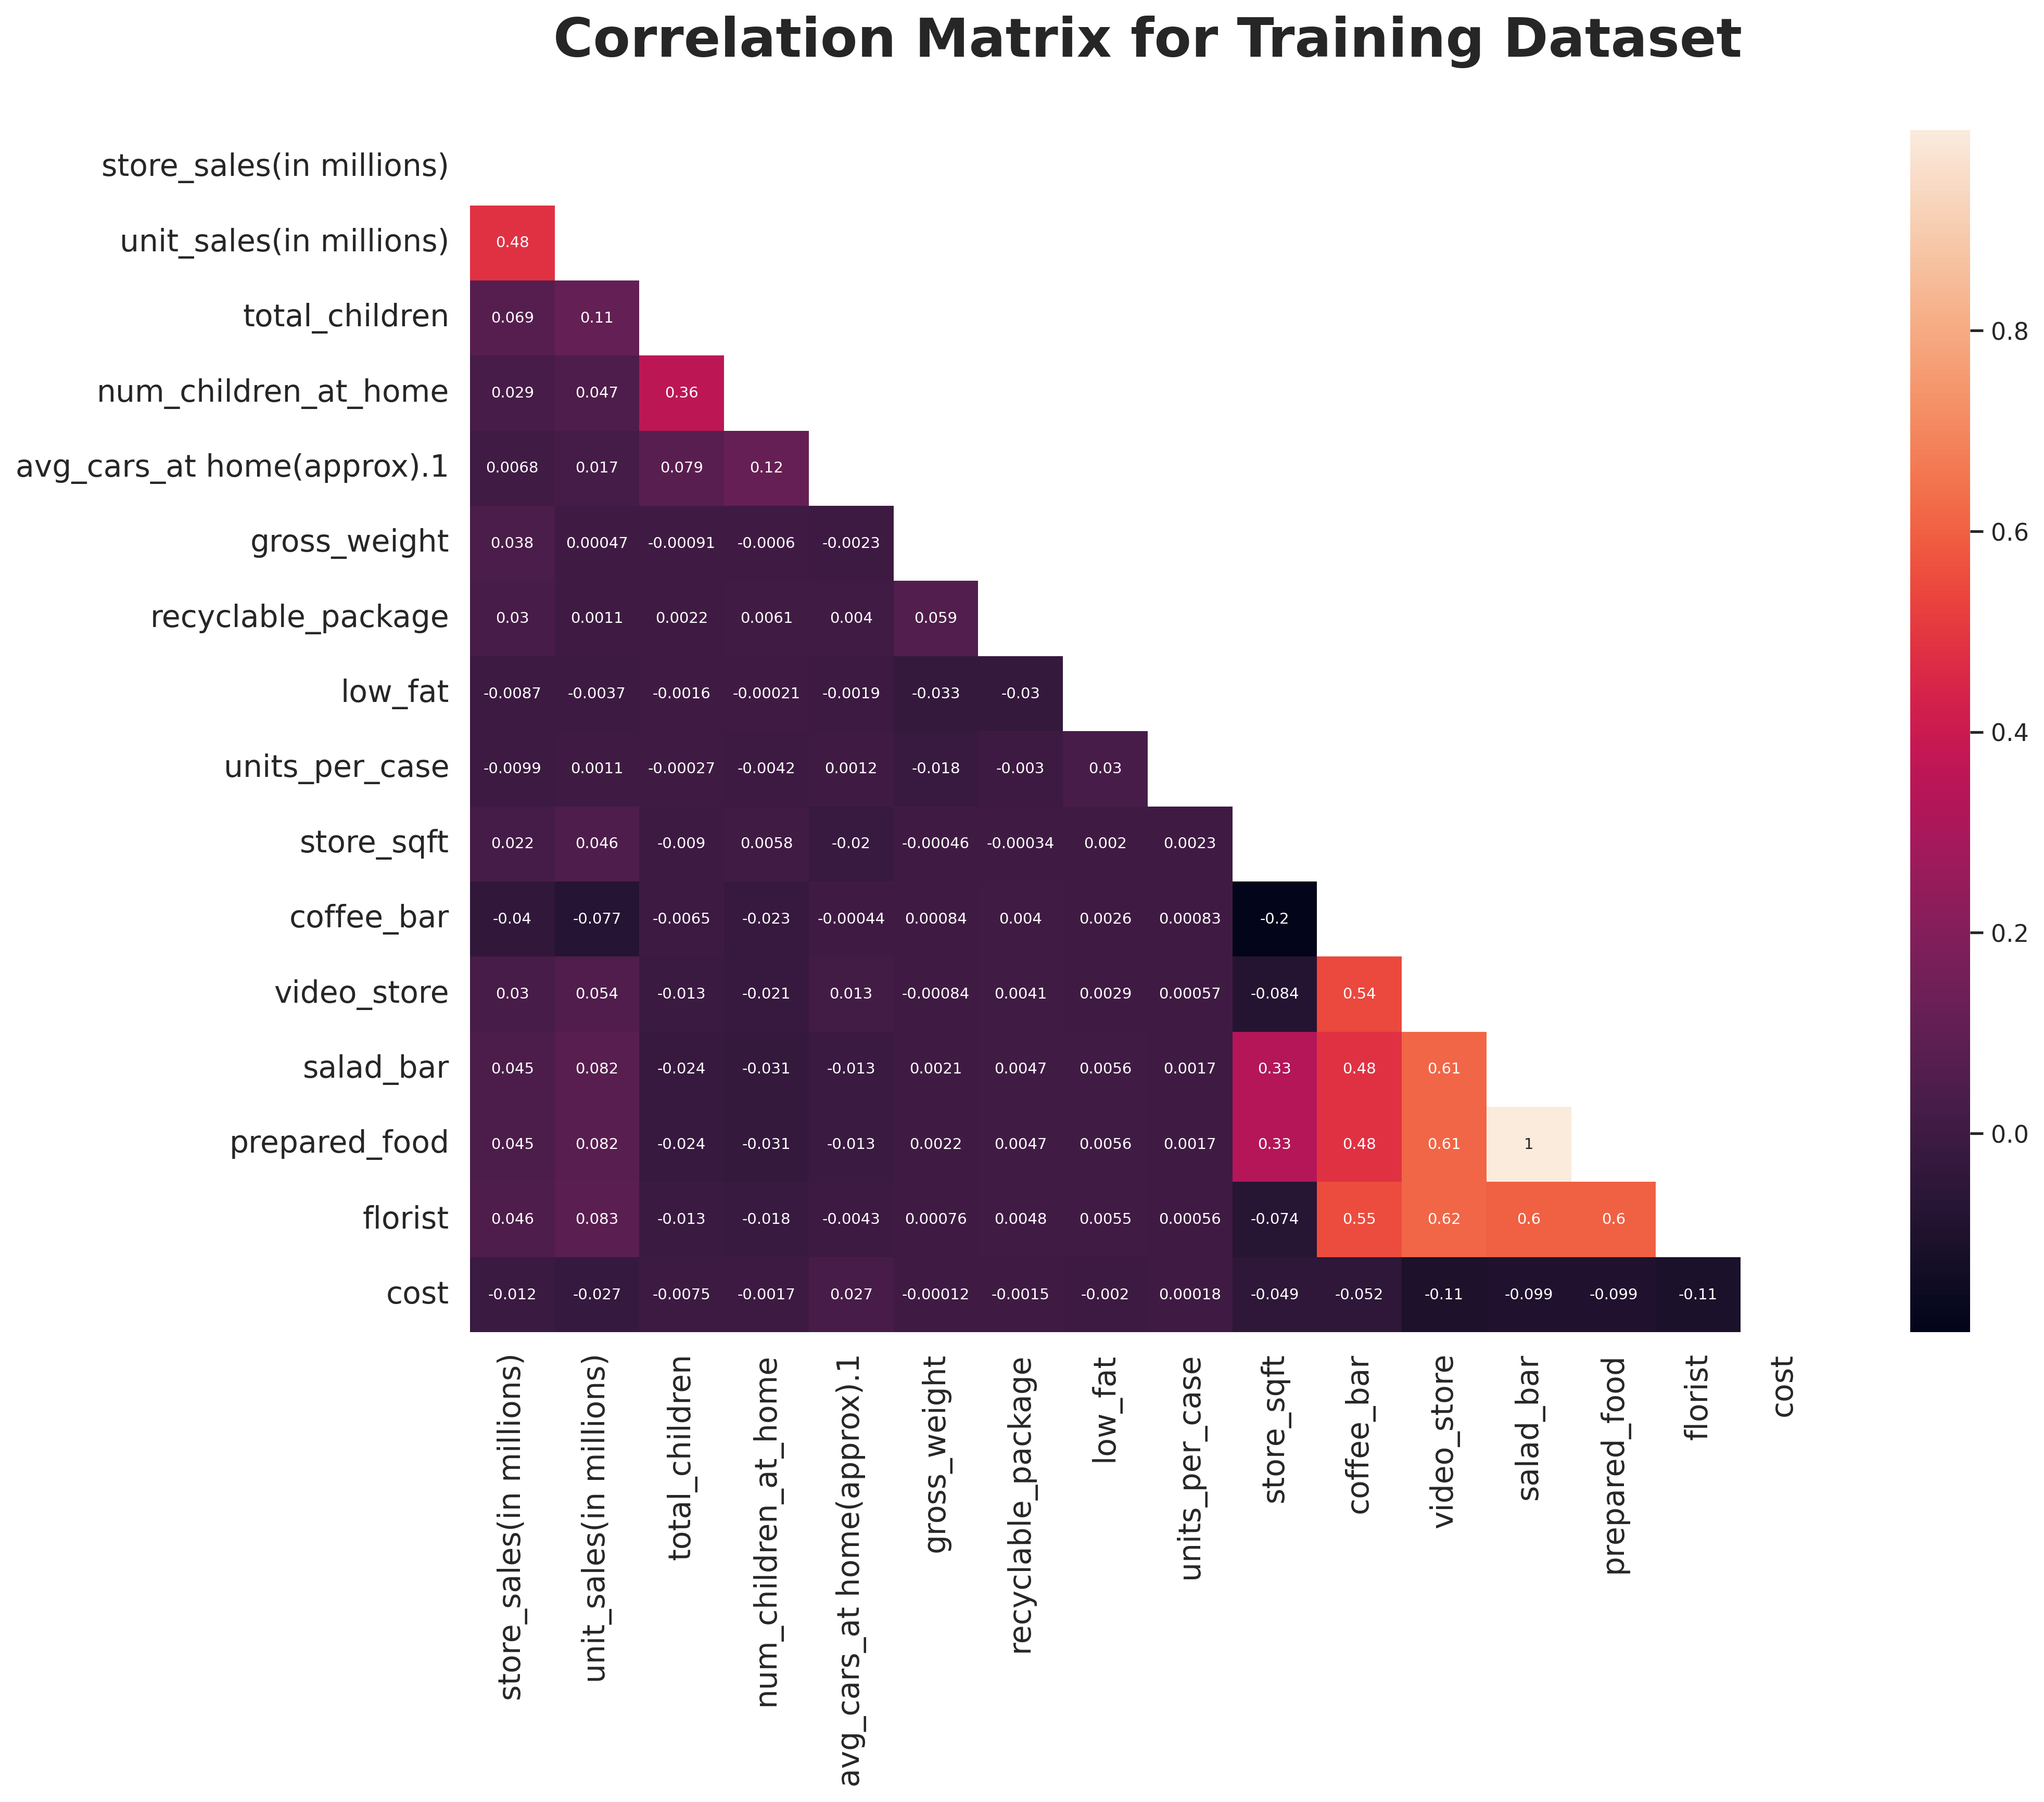

In [91]:
plot_correlation_heatmap(training_dataset, 'Training')

2. Testing Dataset

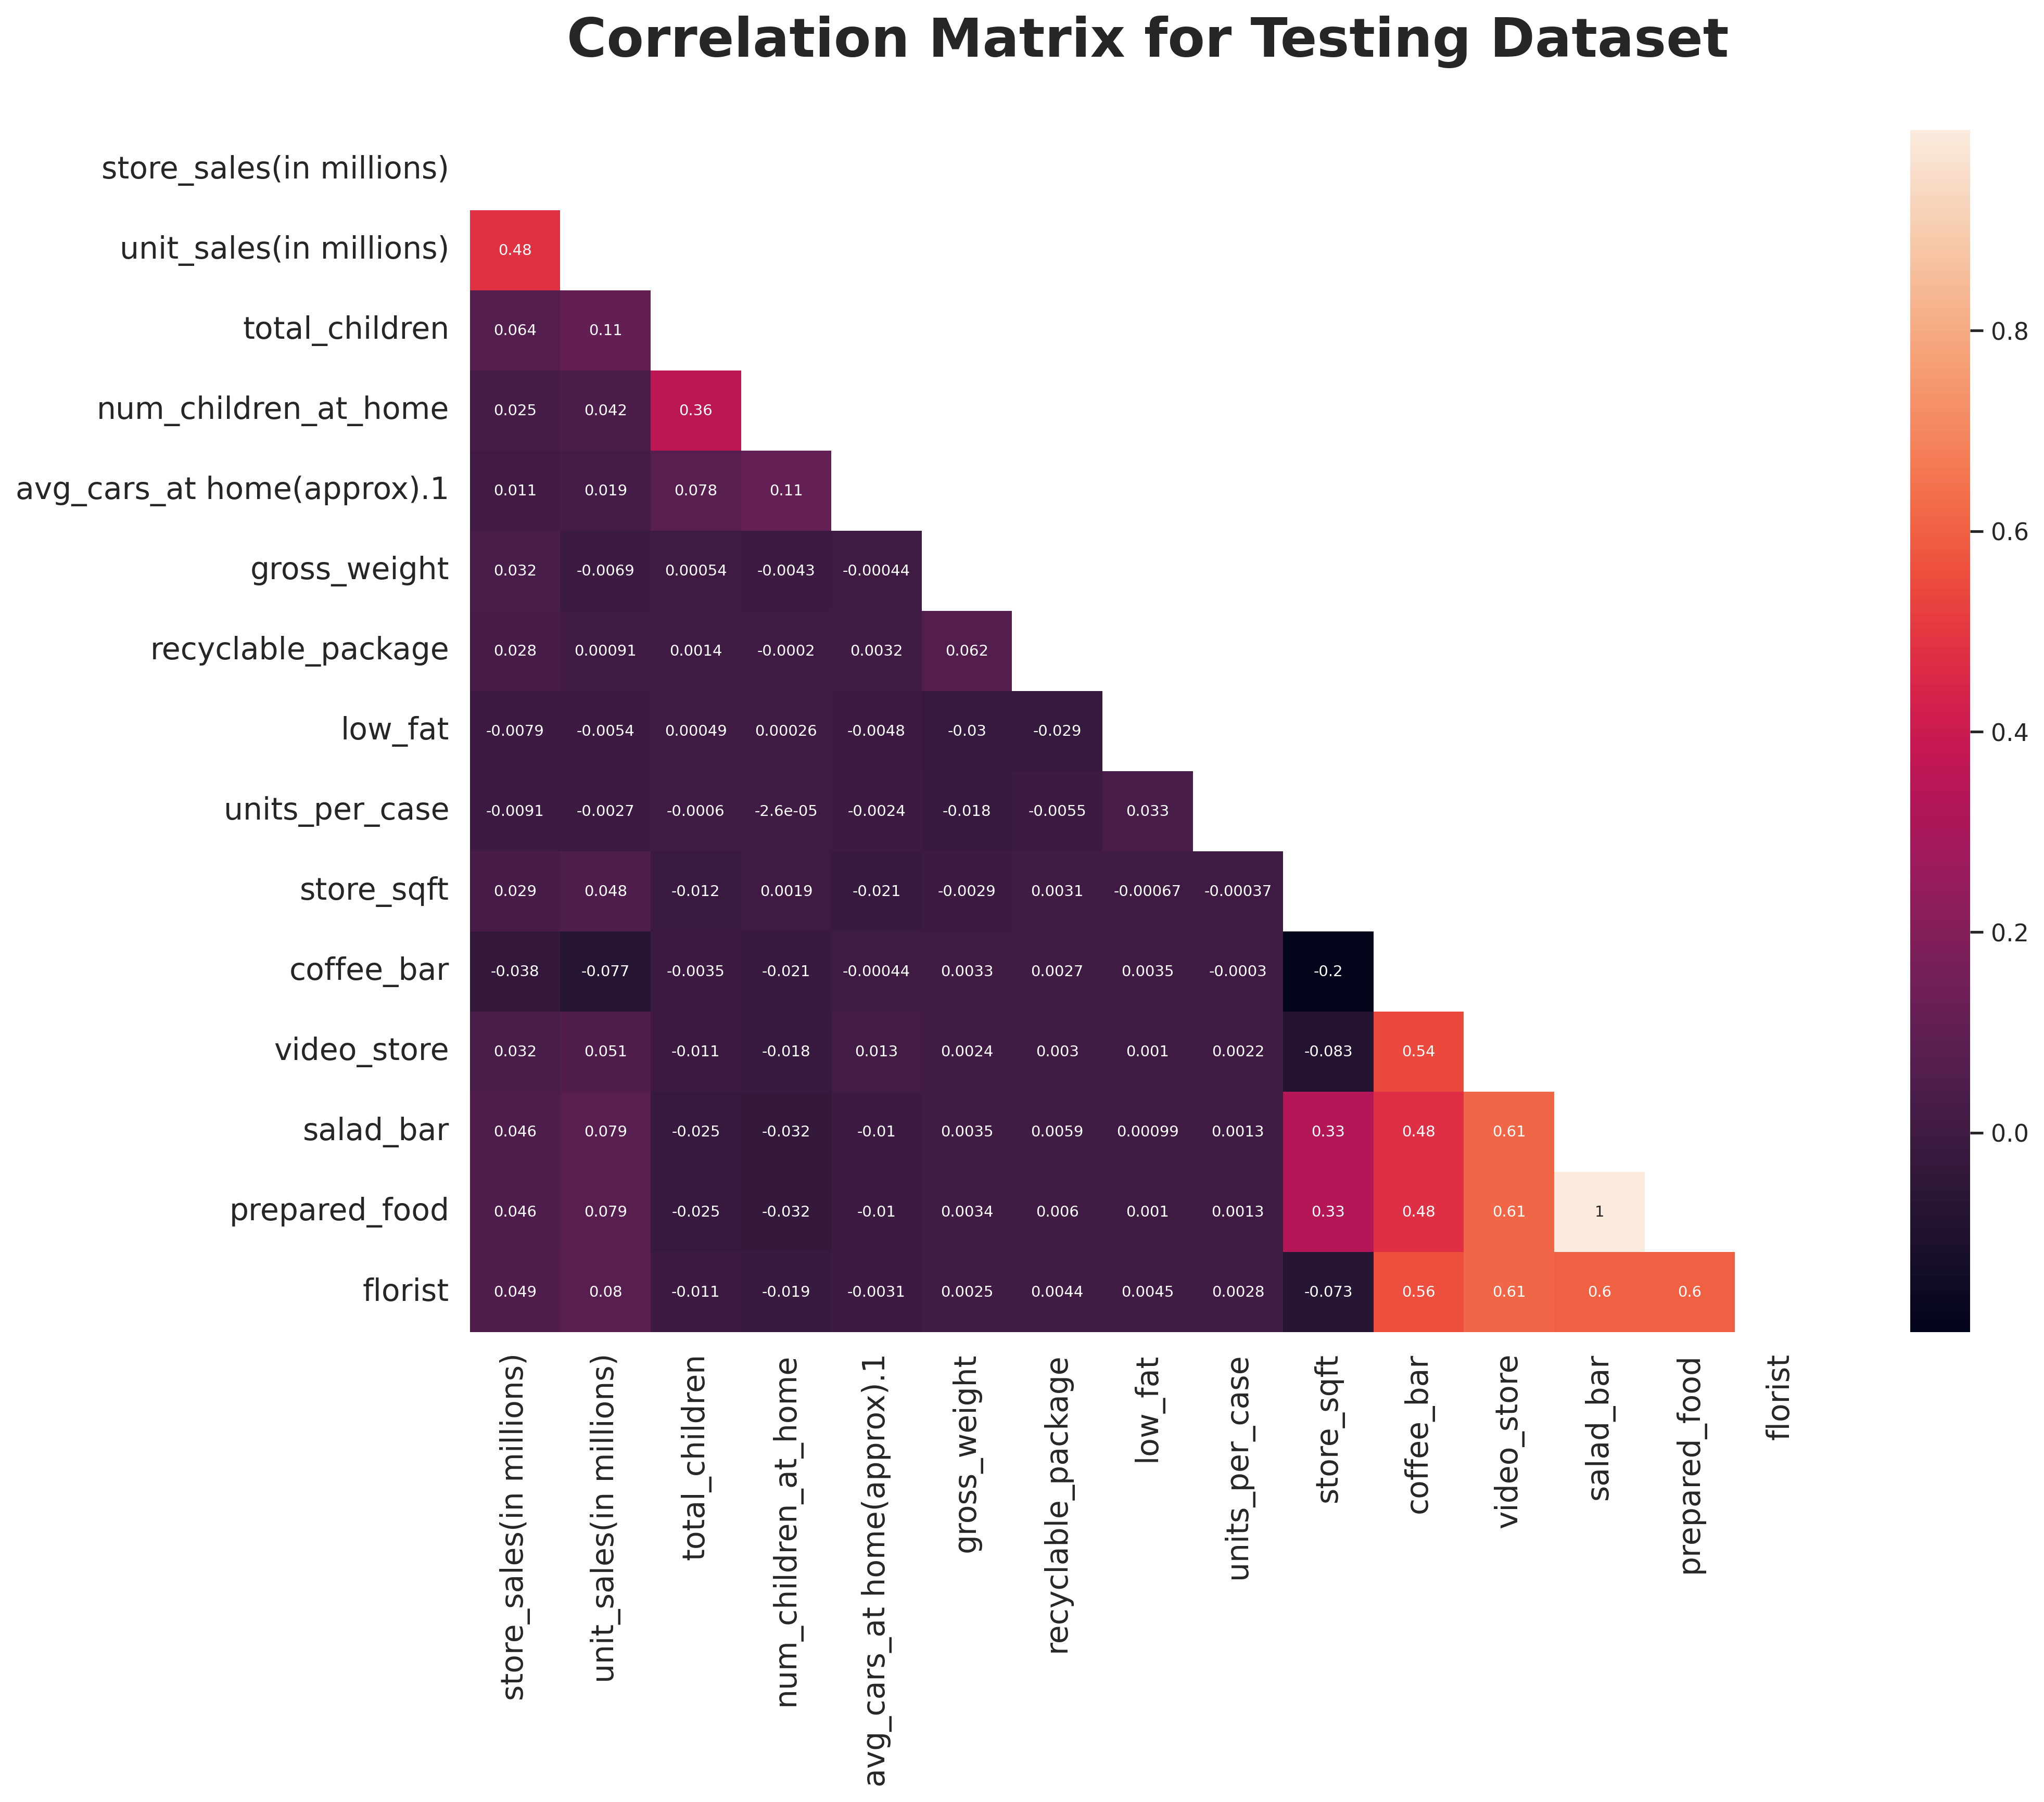

In [92]:
plot_correlation_heatmap(testing_dataset, 'Testing')

* Perfect correlation between '**salad_bar**' and '**prepared_food**' implies that all '**prepared_food**' items originate from the '**salad_bar**.' Removing one of these variables should improve our results.

# Feature Engineering

## Separate Features and Target Labels from Datasets

In [93]:
train_features = training_dataset.drop(columns='cost')
train_target = training_dataset['cost']

In [94]:
test_features = testing_dataset.copy()

In [95]:
train_features.head()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0
1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0
2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0
3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0
4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0


In [96]:
train_target.head()

0     62.09
1    121.80
2     83.51
3     66.78
4    111.51
Name: cost, dtype: float64

In [97]:
test_features.head()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
0,7.24,4.0,1.0,0.0,2.0,10.80,0.0,1.0,7.0,20319.0,0.0,0.0,0.0,0.0,0.0
1,6.90,2.0,2.0,2.0,3.0,8.51,1.0,0.0,4.0,33858.0,1.0,0.0,1.0,1.0,1.0
2,8.34,3.0,0.0,0.0,3.0,8.77,0.0,1.0,14.0,39696.0,0.0,0.0,1.0,1.0,0.0
3,5.48,2.0,3.0,3.0,2.0,21.90,1.0,0.0,9.0,23688.0,1.0,1.0,1.0,1.0,1.0
4,4.80,3.0,2.0,0.0,2.0,10.90,1.0,0.0,11.0,27694.0,1.0,1.0,1.0,1.0,1.0


In [98]:
seed = 42
splits = 5

np.random.seed(seed)

cross_validator = KFold(n_splits=splits, random_state=seed, shuffle=True)

## Feature Generation

In [99]:
# Calculate 'child_ratio' and handle infinity and NaN values
train_features['child_ratio'] = train_features['total_children'] / train_features['num_children_at_home']
train_features['child_ratio'].replace([np.inf, -np.inf], 10, inplace=True)
train_features['child_ratio'].fillna(0, inplace=True)

test_features['child_ratio'] = test_features['total_children'] / test_features['num_children_at_home']
test_features['child_ratio'].replace([np.inf, -np.inf], 10, inplace=True)
test_features['child_ratio'].fillna(0, inplace=True)

# Calculate 'store_score'
train_features['store_score'] = train_features['coffee_bar'] + train_features['video_store'] + train_features['salad_bar'] + train_features['florist']
test_features['store_score'] = test_features['coffee_bar'] + test_features['video_store'] + test_features['salad_bar'] + test_features['florist']

#Calculate 'store_score_ratio'
train_features['store_score_ratio'] = train_features['store_sqft'] / train_features['store_score']
test_features['store_score_ratio'] = test_features['store_sqft'] / test_features['store_score']
# Calculate 'independent_child'
train_features['independent_child'] = train_features['total_children'] - train_features['num_children_at_home']
test_features['independent_child'] = test_features['total_children'] - test_features['num_children_at_home']


In [100]:
test_features.shape

(240224, 19)

In [103]:
def rmsle(y_pred, data):

    y_true = np.array(data)
    score = msle(y_true, y_pred, squared = False)

    return 'rmsle', score, False

## Check for Feature Importance

In [104]:
xgb_params = {
    'seed': seed,
    'objective': 'reg:squaredlogerror',
    'eval_metric': 'rmse',
    'tree_method' : 'gpu_hist',
    'n_jobs' : -1,
    'importance_type' : 'total_gain',
    'max_depth' : 12,
    'n_estimators': 100
}

lgbm_params = {
    'seed': seed,
    'objective' : 'regression',
    'metric' : 'custom',
    'device' : 'gpu',
    'n_jobs' : -1,
    'importance_type' : 'gain',
    'max_depth' : 12,
    'n_estimators': 100
}

xgb_importance = np.zeros(len(list(train_features)))
lgbm_importance = np.zeros(len(list(train_features)))

for fold, (train_idx, val_idx) in enumerate(cross_validator.split(train_features)):
    
    xgb_model = XGBRegressor(
        **xgb_params,
        callbacks=[xgb.callback.EarlyStopping(rounds=10,
                                              maximize=False,
                                              save_best=True)]
    )
    
    xgb_model.fit(
        train_features.iloc[train_idx], 
        train_target.iloc[train_idx],
        eval_set = [(train_features.iloc[val_idx], train_target.iloc[val_idx])],
        verbose = False
    )  
    
    lgbm_model = LGBMRegressor(
        **lgbm_params
    )
    
    lgbm_model.fit(
        train_features.iloc[train_idx], 
        train_target.iloc[train_idx],
        eval_set = [(train_features.iloc[val_idx], train_target.iloc[val_idx])],
        eval_metric = rmsle,
        callbacks = [lgbm.log_evaluation(False),
                     lgbm.early_stopping(stopping_rounds = 10, verbose = False)]
    )
    
    xgb_importance += xgb_model.feature_importances_ / splits
    lgbm_importance += lgbm_model.feature_importances_ / splits
    
xgb_info = pd.DataFrame(xgb_importance, index = list(train_features))
lgbm_info = pd.DataFrame(lgbm_importance, index = list(train_features))

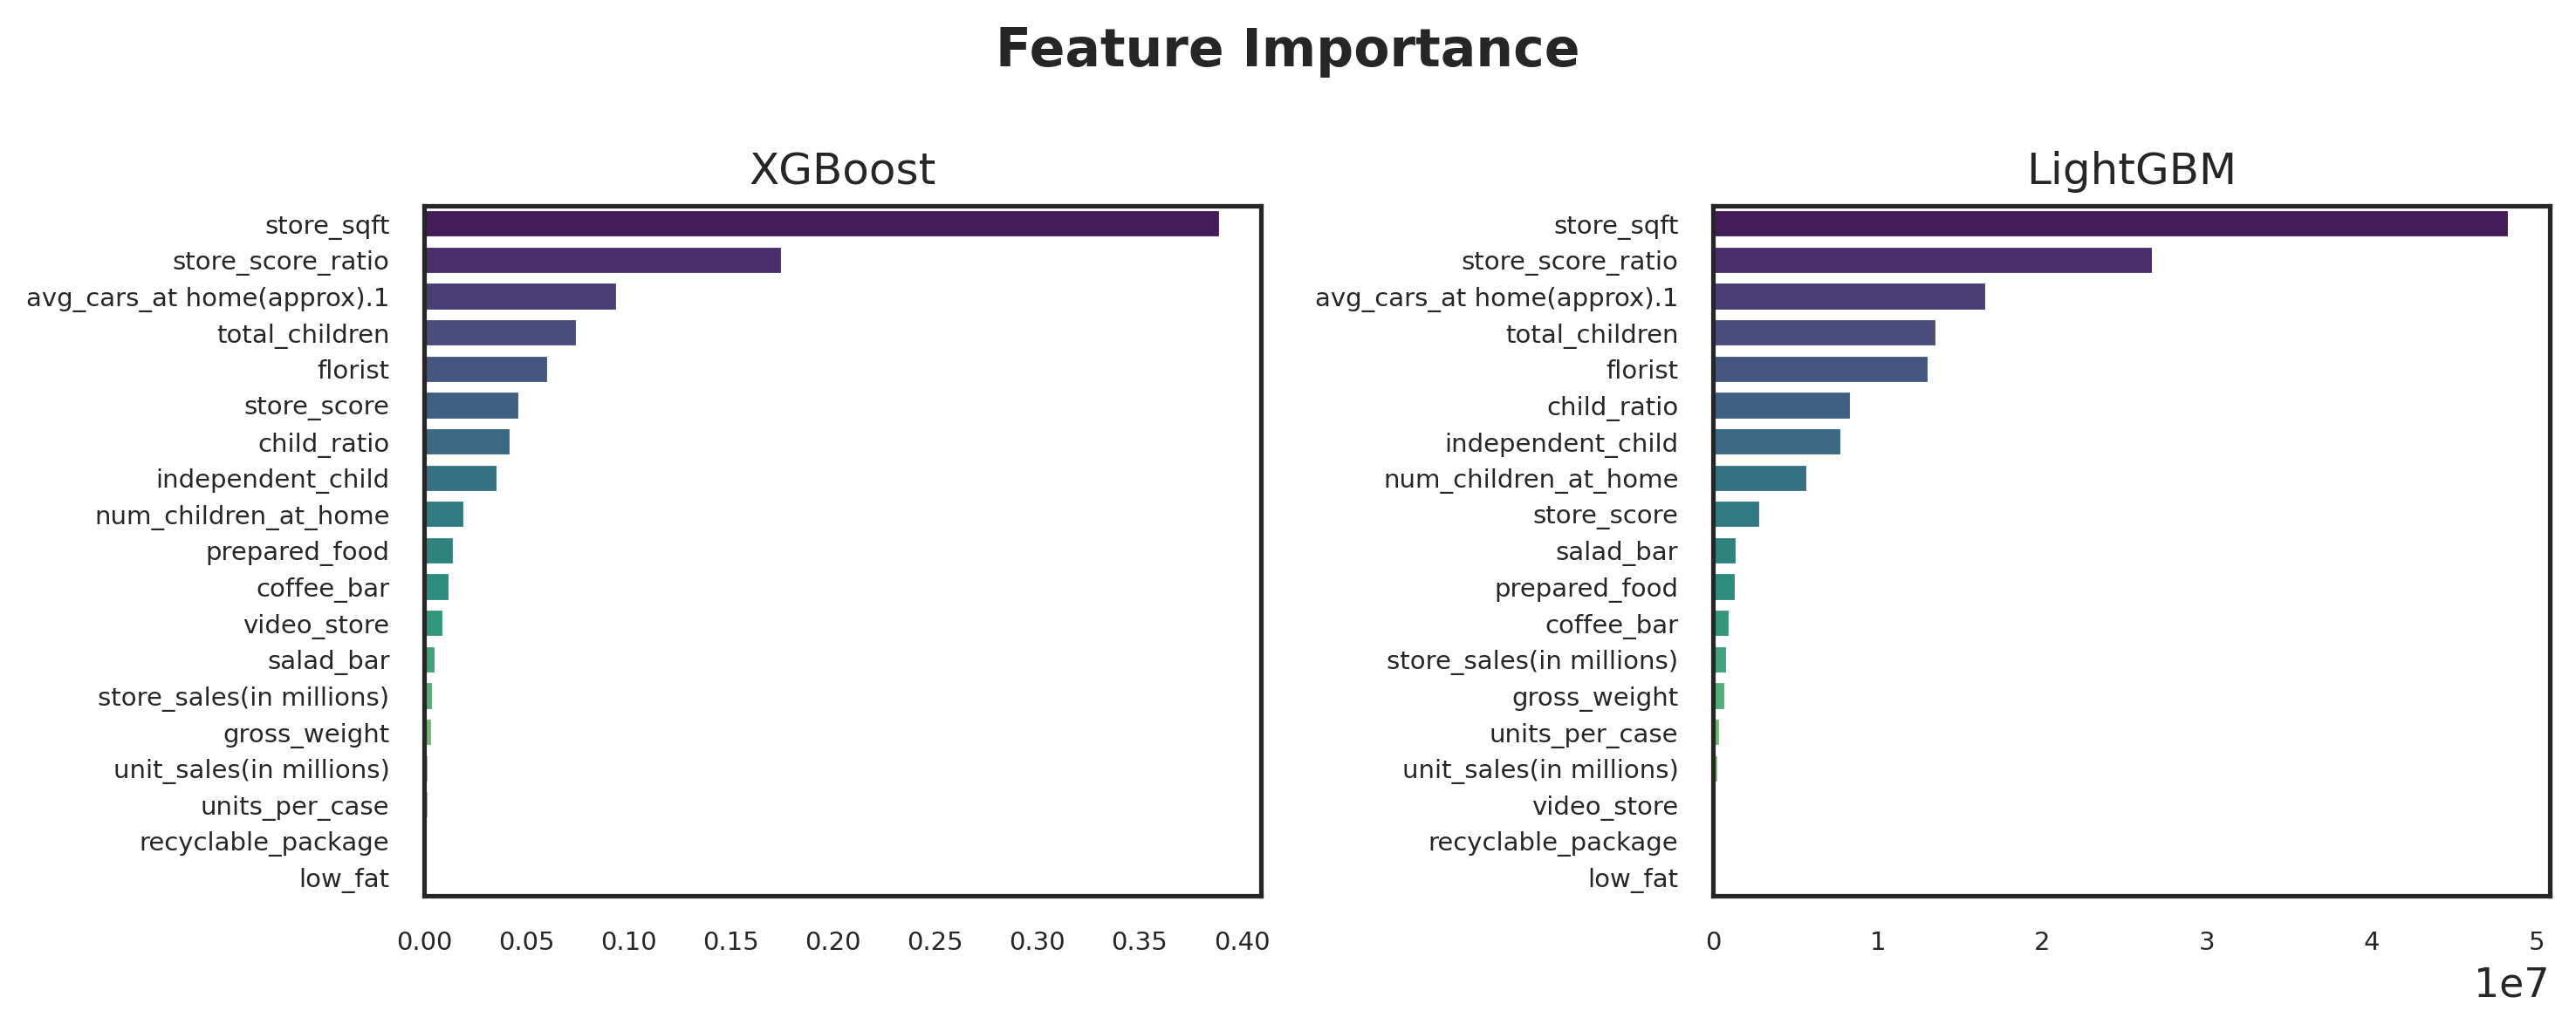

In [105]:
fig, ax = plt.subplots(1, 2, figsize = (10,4), dpi = 300)
ax = ax.flatten()

sns.barplot(xgb_info.sort_values(ascending = False, by = 0).T, orient = 'h', palette = 'viridis', ax = ax[0])
ax[0].set_title('XGBoost')
ax[0].tick_params(axis = 'both', which = 'major', labelsize = 7)

sns.barplot(lgbm_info.sort_values(ascending = False, by = 0).T, orient = 'h', palette = 'viridis', ax = ax[1])
ax[1].tick_params(axis = 'both', which = 'major', labelsize = 7)
ax[1].set_title('LightGBM')

fig.suptitle('Feature Importance', weight = 'bold')
plt.tight_layout()

## Dropping Unimportant Features

In [106]:
drop_features = ['low_fat', 'gross_weight', 'recyclable_package', 'store_sales(in millions)', 'units_per_case', 'unit_sales(in millions)','prepared_food']

train_features.drop(drop_features, axis = 1, inplace = True)
test_features.drop(drop_features, axis = 1, inplace = True)

In [107]:
test_features.shape

(240224, 12)

In [116]:
 def train_and_evaluate_model(train_features, train_target,model,cross_validator=KFold(n_splits=5, shuffle=True, random_state=42)):
    train_scores_rmsle, val_scores_rmsle = [], []
    train_scores_mse, val_scores_mse = [], []
    
    
    for fold, (train_idx, val_idx) in enumerate(cross_validator.split(train_features, train_target)):
        model.fit(
            train_features.iloc[train_idx], 
            train_target.iloc[train_idx]
        )
        
        train_preds = model.predict(train_features.iloc[train_idx])
        val_preds = model.predict(train_features.iloc[val_idx])
        
        train_score_rmsle = mean_squared_log_error(train_target.iloc[train_idx], train_preds,squared=False)
        val_score_rmsle = mean_squared_log_error(train_target.iloc[val_idx], val_preds,squared=False)
        
        train_score_mse = mean_squared_error(train_target.iloc[train_idx], train_preds, squared=False)
        val_score_mse = mean_squared_error(train_target.iloc[val_idx], val_preds, squared=False)
        
        train_scores_rmsle.append(train_score_rmsle)
        val_scores_rmsle.append(val_score_rmsle)
        
        train_scores_mse.append(train_score_mse)
        val_scores_mse.append(val_score_mse)
    
        print(f'Fold {fold}: val RMSLE = {val_score_rmsle:.5f} | train RMSLE = {train_score_rmsle:.5f}')
        print(f'Fold {fold}: val MSE = {val_score_mse:.5f} | train MSE = {train_score_mse:.5f}')
        print()
    
    avg_val_rmsle = np.mean(val_scores_rmsle)
    avg_train_rmsle = np.mean(train_scores_rmsle)
    avg_val_mse = np.mean(val_scores_mse)
    avg_train_mse = np.mean(train_scores_mse)
    
    print(f'Average val RMSLE = {avg_val_rmsle:.5f} | train RMSLE = {avg_train_rmsle:.5f}')
    print(f'Average val MSE = {avg_val_mse:.5f} | train MSE = {avg_train_mse:.5f}')
    
    return avg_val_rmsle, avg_train_rmsle, avg_val_mse, avg_train_mse

## KFold Cross Validation with XGBoost

In [120]:
xgb_params = {
    'seed': seed,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'tree_method' : 'gpu_hist',
    'n_jobs' : -1,
    'importance_type' : 'total_gain',
    'grow_policy' : 'lossguide',
    
    'max_depth' : 20,
    'n_estimators' : 1000,
    'alpha' : 1,
    'lambda' : 0,
    'eta' : .0561418286569673
}
xgb_model = XGBRegressor(**xgb_params)

In [121]:
train_and_evaluate_model(train_features=train_features, train_target=train_target,model=xgb_model,cross_validator=cross_validator)

Fold 0: val RMSLE = 0.29700 | train RMSLE = 0.29460
Fold 0: val MSE = 27.79759 | train MSE = 27.58121

Fold 1: val RMSLE = 0.29536 | train RMSLE = 0.29498
Fold 1: val MSE = 27.67938 | train MSE = 27.61408

Fold 2: val RMSLE = 0.29636 | train RMSLE = 0.29469
Fold 2: val MSE = 27.77849 | train MSE = 27.58575

Fold 3: val RMSLE = 0.29696 | train RMSLE = 0.29465
Fold 3: val MSE = 27.76377 | train MSE = 27.59220

Fold 4: val RMSLE = 0.29727 | train RMSLE = 0.29442
Fold 4: val MSE = 27.87638 | train MSE = 27.56229

Average val RMSLE = 0.29659 | train RMSLE = 0.29467
Average val MSE = 27.77912 | train MSE = 27.58711


(0.29659003136789686,
 0.29466880826805764,
 27.779122798865224,
 27.58710869913413)

## KFold Cross Validation with CatBoost

In [123]:
cb_params = {
    'random_seed': seed,
    'loss_function' : 'RMSE',
    'eval_metric' : 'RMSE',
    'task_type' : 'GPU',
    'bootstrap_type' : 'Bernoulli',
    'verbose' : False,
    
    'n_estimators' : 1000, 
    'max_depth' : 11,
    'learning_rate' : .09373739891212098,
    'min_data_in_leaf' : 1,
    'reg_lambda' : 10,
    'subsample' : 1
}
cb_model = CatBoostRegressor(**cb_params)

In [124]:
train_and_evaluate_model(train_features=train_features, train_target=train_target,model=cb_model,cross_validator=cross_validator)

Fold 0: val RMSLE = 0.29684 | train RMSLE = 0.29483
Fold 0: val MSE = 27.77623 | train MSE = 27.59964

Fold 1: val RMSLE = 0.29506 | train RMSLE = 0.29524
Fold 1: val MSE = 27.64572 | train MSE = 27.63424

Fold 2: val RMSLE = 0.29619 | train RMSLE = 0.29493
Fold 2: val MSE = 27.75666 | train MSE = 27.60479

Fold 3: val RMSLE = 0.29672 | train RMSLE = 0.29497
Fold 3: val MSE = 27.73231 | train MSE = 27.61772

Fold 4: val RMSLE = 0.29711 | train RMSLE = 0.29468
Fold 4: val MSE = 27.85758 | train MSE = 27.58230

Average val RMSLE = 0.29638 | train RMSLE = 0.29493
Average val MSE = 27.75370 | train MSE = 27.60774


(0.29638485105535395,
 0.2949319083247601,
 27.753698812449255,
 27.607737343229907)

## KFold Cross Validation with Stacking Approch with XGBoost & CatBoost

In [126]:
stack_model =StackingRegressor([('xgb', XGBRegressor(**xgb_params)),('cb', CatBoostRegressor(**cb_params))])

In [127]:
train_and_evaluate_model(train_features=train_features, train_target=train_target,model=stack_model,cross_validator=cross_validator)

Fold 0: val RMSLE = 0.29690 | train RMSLE = 0.29490
Fold 0: val MSE = 27.77526 | train MSE = 27.59957

Fold 1: val RMSLE = 0.29514 | train RMSLE = 0.29529
Fold 1: val MSE = 27.64634 | train MSE = 27.63125

Fold 2: val RMSLE = 0.29629 | train RMSLE = 0.29503
Fold 2: val MSE = 27.75791 | train MSE = 27.60626

Fold 3: val RMSLE = 0.29678 | train RMSLE = 0.29495
Fold 3: val MSE = 27.73351 | train MSE = 27.61001

Fold 4: val RMSLE = 0.29716 | train RMSLE = 0.29474
Fold 4: val MSE = 27.85495 | train MSE = 27.58114

Average val RMSLE = 0.29645 | train RMSLE = 0.29498
Average val MSE = 27.75359 | train MSE = 27.60565


(0.2964539453315744,
 0.29498247980150755,
 27.753592961624843,
 27.605646755086962)

## KFold Cross Validation with Voting Approch with XGBoost & CatBoost

In [128]:
vote_model = VotingRegressor([('xgb', XGBRegressor(**xgb_params)),('cb', CatBoostRegressor(**cb_params))])

In [129]:
train_and_evaluate_model(train_features=train_features, train_target=train_target,model=vote_model,cross_validator=cross_validator)

Fold 0: val RMSLE = 0.29684 | train RMSLE = 0.29468
Fold 0: val MSE = 27.77917 | train MSE = 27.58594

Fold 1: val RMSLE = 0.29513 | train RMSLE = 0.29506
Fold 1: val MSE = 27.65467 | train MSE = 27.61909

Fold 2: val RMSLE = 0.29621 | train RMSLE = 0.29476
Fold 2: val MSE = 27.76087 | train MSE = 27.59011

Fold 3: val RMSLE = 0.29675 | train RMSLE = 0.29473
Fold 3: val MSE = 27.74011 | train MSE = 27.59761

Fold 4: val RMSLE = 0.29712 | train RMSLE = 0.29450
Fold 4: val MSE = 27.85921 | train MSE = 27.56741

Average val RMSLE = 0.29641 | train RMSLE = 0.29475
Average val MSE = 27.75881 | train MSE = 27.59203


(0.29640780995425053,
 0.2947470606693726,
 27.75880543086768,
 27.592033161568803)

# Final Model

## Combine Original & Training Datasets

In [130]:
combined_training_dataset = pd.concat([training_dataset, original_training_dataset])
combined_training_dataset.drop_duplicates(subset = list(training_dataset)[0:-1], inplace = True)

combined_features = combined_training_dataset.iloc[:, :-1]
combined_features = combined_features.drop(drop_features, axis = 1)
combined_target = combined_training_dataset['cost']
#combined_target = np.log1p(combined_target)


In [131]:
combined_features.head()

,total_children,num_children_at_home,avg_cars_at home(approx).1,store_sqft,coffee_bar,video_store,salad_bar,florist
0,2.0,2.0,2.0,36509.0,0.0,0.0,0.0,0.0
1,4.0,0.0,3.0,28206.0,1.0,0.0,0.0,0.0
2,0.0,0.0,3.0,21215.0,1.0,0.0,0.0,0.0
3,5.0,0.0,0.0,21215.0,1.0,0.0,0.0,0.0
4,5.0,0.0,3.0,27694.0,1.0,1.0,1.0,1.0


## Feature Engineering for Combined Datasets

In [132]:
# Calculate 'child_ratio' and handle infinity and NaN values
combined_features['child_ratio'] = combined_features['total_children'] / combined_features['num_children_at_home']
combined_features['child_ratio'].replace([np.inf, -np.inf], 10, inplace=True)
combined_features['child_ratio'].fillna(0, inplace=True)

# Calculate 'store_score'
combined_features['store_score'] = combined_features['coffee_bar'] + combined_features['video_store'] + combined_features['salad_bar'] + combined_features['florist']

#Calculate 'store_score_ratio'
combined_features['store_score_ratio'] = combined_features['store_sqft'] / combined_features['store_score']

# Calculate 'independent_child'
combined_features['independent_child'] = combined_features['total_children'] - combined_features['num_children_at_home']


## Stacking Approch with XGBoost & CatBoost

In [133]:
stack = StackingRegressor([('xgb', XGBRegressor(**xgb_params)),('cb', CatBoostRegressor(**cb_params))])
stack.fit(combined_features, combined_target)

StackingRegressor(estimators=[('xgb',
                               XGBRegressor(alpha=1, base_score=None,
                                            booster=None, callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eta=0.0561418286569673,
                                            eval_metric='rmse',
                                            feature_types=None, gamma=None,
                                            gpu_id=None,
                                            grow_policy='lossguide',
                                            importance_type='total_gain',
                                            interaction_constraints=None,
                                            lambda=0, learning_rate=None,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=20,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=1000, n_jobs=-1, ...)),
                              ('cb',
                               <catboost.core.CatBoostRegressor object at 0x7fb75026cc70>)])

## Saving the Model

In [ ]:
import joblib
joblib.dump(stack, 'final_model.joblib')

## Getting Results

In [ ]:
stack_preds = pd.DataFrame({'cost': stack.predict(test_features)})
result = pd.concat([testing_ids, stack_preds], axis=1)

## Saving the CSV File

In [ ]:
result['cost'] = np.expm1(result['cost'])
result.to_csv('submision.csv', index = False)